# PWV Modeling

This notebook outlines an approach for modeling time variable precipitable water vapor (PWV) using real world weather data taken by the SuomiNet project.


In [1]:
from datetime import datetime
from pathlib import Path

from matplotlib import pyplot as plt
from pwv_kpno.gps_pwv import GPSReceiver

from snat_sim import plotting, models


In [2]:
fig_dir = Path('.').resolve() / 'figs' / 'pwv_modeling'
fig_dir.mkdir(exist_ok=True)


## The Approach

To create a physically reasonable representation of the atmospheric variability at LSST, we use PWV measurements taken at the nearby Cerro Telolo International Observatory (CTIO).

In [3]:
ctio = GPSReceiver('CTIO', data_cuts={'PWV': [(0, 25)]})
ctio.download_available_data(year=range(2012, 2018))


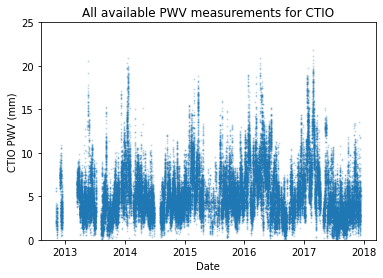

In [4]:
ctio_weather = ctio.weather_data()

ctio_weather.reset_index().plot.scatter('date', 'PWV', s=1, alpha=.2)
plt.ylabel('CTIO PWV (mm)')
plt.xlabel('Date')
plt.title('All available PWV measurements for CTIO')
plt.ylim(0, 25)
plt.show()


Unfortunately, we don't have enough data to fully represent an entire astronomical survey (at least not for the ten years of Rubin LSST). The time span is too short and the periods of missing data are sometimes significant.
As an alternative we focus on describing the seasonal variability by considering data from a single year with good measurement coverage. The idea is to select a single representative year, and then use that year as a model for how PWV varies across each season.

Shown below, the two years with the best coverage are 2016 and 2017.

Averages for 2012:
Summer Average:  nan +\-  nan mm
Fall Average:   nan +\-  nan mm
Winter Average:  nan +\-  nan mm
Spring Average:  4.23 +\-  2.30 mm


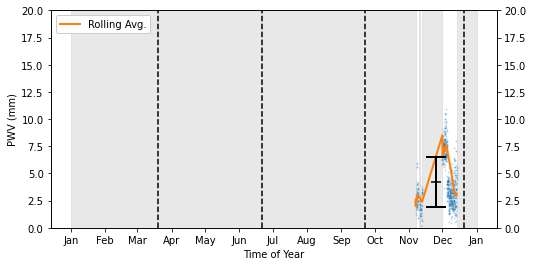

Averages for 2013:
Summer Average:  6.45 +\-  2.28 mm
Fall Average:   4.85 +\-  2.27 mm
Winter Average:  3.95 +\-  2.34 mm
Spring Average:  4.32 +\-  2.16 mm


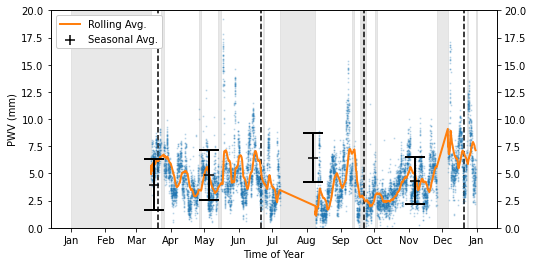

Averages for 2014:
Summer Average:  6.59 +\-  3.29 mm
Fall Average:   4.49 +\-  1.71 mm
Winter Average:  4.04 +\-  1.85 mm
Spring Average:  4.54 +\-  1.69 mm


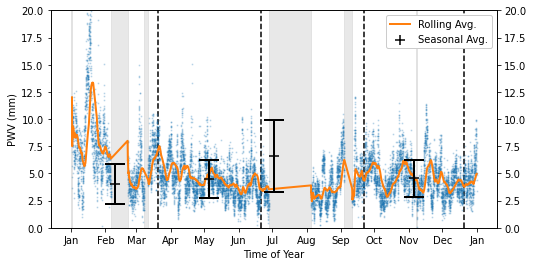

Averages for 2015:
Summer Average:  6.46 +\-  2.59 mm
Fall Average:   5.62 +\-  3.14 mm
Winter Average:  5.44 +\-  2.41 mm
Spring Average:  5.17 +\-  1.95 mm


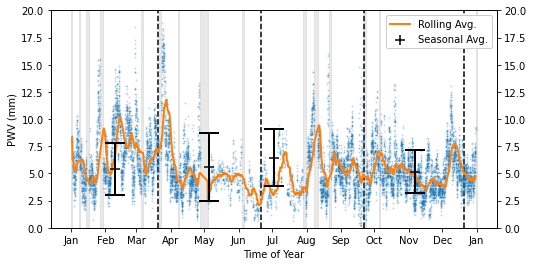

Averages for 2016:
Summer Average:  7.13 +\-  2.90 mm
Fall Average:   7.44 +\-  3.18 mm
Winter Average:  3.93 +\-  2.12 mm
Spring Average:  4.95 +\-  2.18 mm


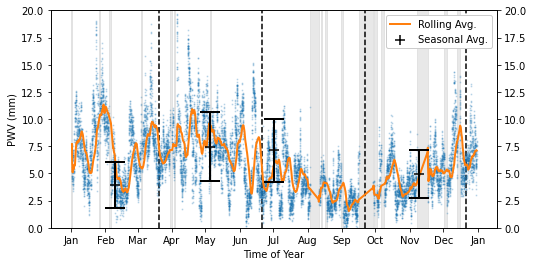

Averages for 2017:
Summer Average:  8.75 +\-  3.93 mm
Fall Average:   5.07 +\-  2.56 mm
Winter Average:  3.12 +\-  1.79 mm
Spring Average:  4.46 +\-  2.10 mm


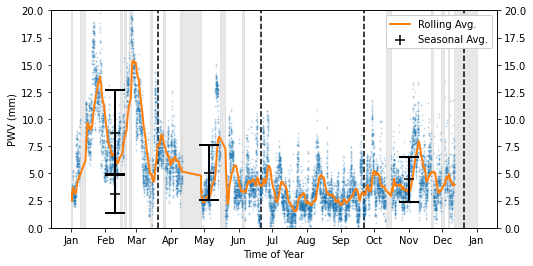

In [5]:
for year in range(2012, 2018):
    weather_for_year = ctio_weather[ctio_weather.index.year == year]
    print(f'Averages for {year}:')
    
    plotting.plot_year_pwv_vs_time(weather_for_year.PWV)
    plt.savefig(fig_dir / f'ctio_{year}.pdf')
    plt.show()


No matter which year we pick, we will need to supplement the data set to fill in for missing measurements. Instead of thinking through some fancy statistics, we keep our approach simple and supplement missing data from 2016 with measurements taken in 2017.


Summer Average:  7.18 +\-  2.95 mm
Fall Average:   7.33 +\-  3.17 mm
Winter Average:  3.79 +\-  2.09 mm
Spring Average:  4.88 +\-  2.20 mm


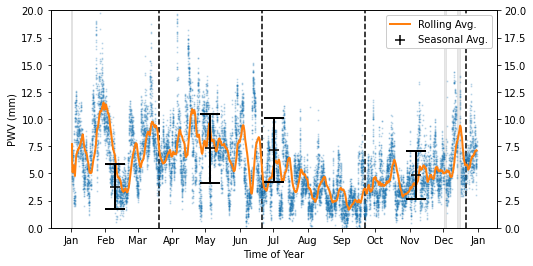

In [6]:
supplemented_pwv = ctio_weather.PWV.tsu.supplemented_data(2016, [2017])
plotting.plot_year_pwv_vs_time(supplemented_pwv)

plt.savefig(fig_dir / f'2016_supp_with_2017.pdf')
plt.show()


Supplementing the data does an admirable job of eliminating missing data, but there are still a few periods missing in the above figure. Fortunately these time-spans are short, so they can be interpolated over. We handle this as follows:

1. Resample the PWV data uniformly from the beginning through the end of the year.
2. Enforce periodic boundary conditions between the beginning and end of the year. This avoids extrapolation and enforces a smooth transition between seasons.
3. Interpolate linearly for any missing data (while maintaining the boundary conditions)


Summer Average:  7.18 +\-  2.91 mm
Fall Average:   7.33 +\-  3.17 mm
Winter Average:  3.78 +\-  2.09 mm
Spring Average:  4.97 +\-  2.25 mm


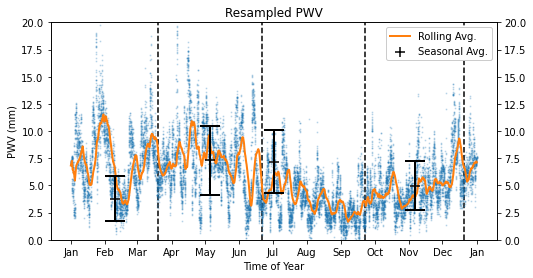

In [7]:
resampled_pwv = supplemented_pwv.tsu.resample_data_across_year()
interpolated_pwv = resampled_pwv.tsu.periodic_interpolation()
plotting.plot_year_pwv_vs_time(interpolated_pwv)
plt.title('Resampled PWV');


The final step is to build a model that interpolates the PWV rom our supplemented data for a given time of year.

In [8]:
pwv_model = models.PWVModel(supplemented_pwv)


We make a quick validation plot to check the interpolation function.


In [9]:
def plot_interpolation_validation(pwv_data, pwv_model_obj):
    """Over plot the modeled and measured PWV
    
    Args:
        pwv_data    (Series): Series with PWV values and a Datetime index
        pwv_model_obj (PWVModel): PWV model to plot
    """
    
    pwv_data = pwv_data.sort_index()
    interpolated_pwv_data = pwv_model_obj.pwv_zenith(pwv_data.index, time_format=None)

    plt.figure(figsize=(10, 5))
    plt.scatter(pwv_data.index, pwv_data.values, s=2, alpha=.1, label='Measured')
    plt.plot(pwv_data.index, interpolated_pwv_data, label='Interpolated', color='C1', alpha=.75)
    plt.ylabel('PWV (mm)')
    plt.xlabel('Date (UTC)')
    plt.legend()


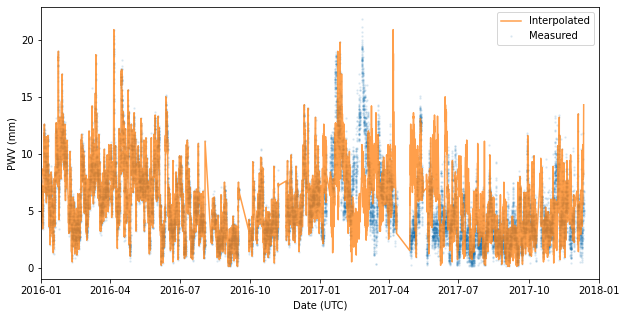

In [10]:
plot_interpolation_validation(ctio_weather.PWV, pwv_model)
plt.xlim(datetime(2016, 1, 1), datetime(2018, 1, 1))
plt.show()


## Automated Model Building

The process outlined above is can be automated by building a `PWVModel` instance directly from a `GPSReceiver` object.

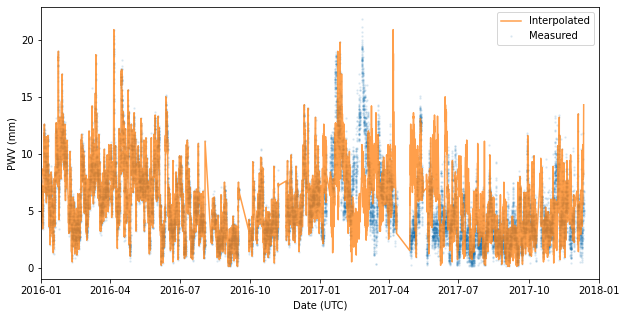

In [11]:
auto_built_model = models.PWVModel.from_suominet_receiver(ctio, 2016, [2017])

plot_interpolation_validation(ctio_weather.PWV, auto_built_model)
plt.xlim(datetime(2016, 1, 1), datetime(2018, 1, 1))
plt.show()


## Propagation Effects

PWV models can be used to add propagation effects to supernova model instances. Propagation effects describe how the the spectral energy distribution of a model is effected by intervening phenomena (in this case, the absorption of light by the atmosphere).

Propagation effects can represent a time constant PWV concentration, time variable PWV at the full temporal resolution of the underlying model, and as a binned average per season. We demonstrate all three below.


In [12]:
# Static effects set PWV according to a user definable value
static_prop = models.StaticPWVTrans()
static_prop['pwv'] = 4

# Seasonal effects also have user definable pwv parameters (one per season)
# or you can determine the seasonal averages from a PWV model
seasonal_prop = models.SeasonalPWVTrans.from_pwv_model(auto_built_model)

# Variable effects pull PWV values from an underlying model
variable_prop = models.VariablePWVTrans(auto_built_model)


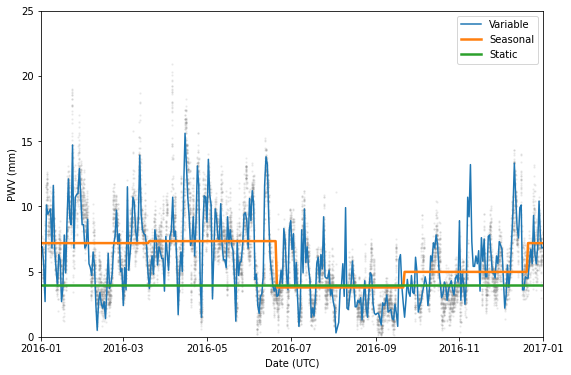

In [13]:
plotting.compare_prop_effects(ctio_weather.PWV, static_prop, seasonal_prop, variable_prop)
plt.xlim(datetime(2016, 1, 1), datetime(2017, 1, 1));


## Impact on SN Spectra

To understand the impact of seasonal PWV variability (in a very rudimentary way) we compare the atmospheric transmission for the lowest and highest average seasonal PWV as determined from the final PWV variability model shown above.


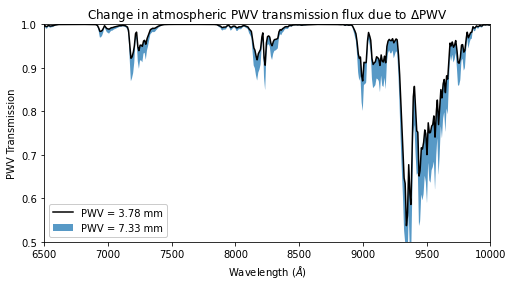

In [14]:
plotting.plot_transmission_variation(3.78, 7.33)
plt.savefig(fig_dir / f'transmission_variation.pdf')


We also make a similar comparison using the observed SN Ia spectrum (at a given redshift).

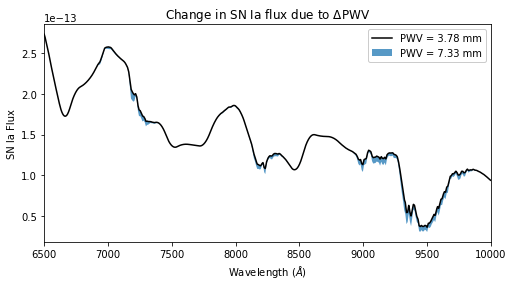

In [15]:
plotting.plot_flux_variation(3.78, 7.33, z=.55)
plt.savefig(fig_dir / f'flux_variation.pdf')


The plot above is going to depend heavily on the chosen redshift. To better understand this dependence, we can visualize the absolute change in spectral flux due to PWV (i.e., the change in flux relative to PWV=0). Some key take points:

1. The first and second absorption feature have a much smaller effect than the reddest shown feature. This is expected since PWV absorbs less light at bluer wavelengths. However, since SNe emit much more light at these wavelengths, the effect should not be ignored.
2. The above statement is less important for the second feature when speaking photometrically because the absorption feature falls between bandpass curves.
3. There is an oscillatory nature in the change in flux as a function of redshift. This is most visible for the reddest feature, yet is present across the plot. This can be attributed to the non-trivial interplay of the broad absorption features of SNe Ia and the absorption features of the atmosphere.


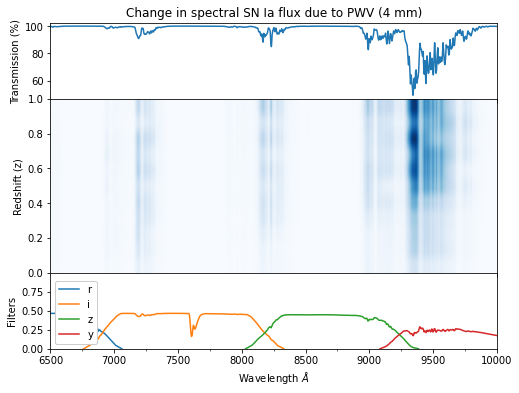

In [16]:
plotting.plot_delta_sn_flux(pwv=4)
plt.savefig(fig_dir / f'delta_sn_flux.pdf')
